In [1]:
#importing libraries

import pandas as pd 
import sqlite3

In [2]:
def clean_and_transform(df):

    # Convert dates
    df["orderdatum"] = pd.to_datetime(df["orderdatum"], errors="coerce")
    df["leveransdatum"] = pd.to_datetime(df["leveransdatum"], errors="coerce")

    # Convert numeric
    df["antal"] = pd.to_numeric(df["antal"], errors="coerce")
    df["pris_per_enhet"] = pd.to_numeric(df["pris_per_enhet"], errors="coerce")

    # Drop missing critical fields
    df = df.dropna(subset=[
        "orderdatum",
        "leveransdatum",
        "antal",
        "pris_per_enhet"
    ])

    # Fill optional columns
    for col in ["region", "betalmetod", "leveransstatus"]:
        if col in df.columns:
            df[col] = df[col].fillna("Unknown")

    # Feature engineering
    df["revenue"] = df["antal"] * df["pris_per_enhet"]
    df["lead_time_days"] = (
        df["leveransdatum"] - df["orderdatum"]
    ).dt.days

    df["order_weekday"] = df["orderdatum"].dt.day_name()
    df["order_month"] = df["orderdatum"].dt.month

    return df


In [3]:
def run_pipeline(csv_path, db_path, table_name):

    # EXTRACT
    df_raw = pd.read_csv(csv_path)

    # TRANSFORM
    df_clean = clean_and_transform(df_raw.copy())

    # LOAD
    conn = sqlite3.connect(db_path)

    df_clean.to_sql(
        table_name,
        conn,
        if_exists="replace",
        index=False
    )

    # VERIFY
    loaded_count = pd.read_sql(
        f"SELECT COUNT(*) AS n FROM {table_name}",
        conn
    )["n"].iloc[0]

    conn.close()

    return df_raw, df_clean, loaded_count


In [4]:
# Extract and transform

df = pd.read_csv("../data/raw/nordtech_data.csv")

df.head()


,order_id,orderrad_id,orderdatum,leveransdatum,produkt_sku,produktnamn,kategori,antal,pris_per_enhet,region,kundtyp,betalmetod,kund_id,leveransstatus,recension_text,recensionsdatum,betyg
0,ORD-2024-00001,ORD-2024-00001-1,2024-05-19,2024-05-22,SKU-WC001,Webbkamera HD,Tillbehör,1,SEK 799,Uppsala,Privat,Kort,KND-53648,Levererad,NaN,NaN,NaN
1,ORD-2024-00002,ORD-2024-00002-1,2024-12-02,5 december 2024,SKU-HB001,USB-C Hub 7-port,Tillbehör,1,549.00,Göteborg,Privat,Swish,KND-84095,Levererad,NaN,NaN,NaN
2,ORD-2024-00003,ORD-2024-00003-1,2024-12-31,2025-01-03,SKU-SD001,Extern SSD 1TB,Lagring,1,1199.00,NaN,Företag,Faktura,KND-91748,Levererad,Stämmer inte överens med produktbeskrivningen.,2025-01-12,2.0
3,ORD-2024-00003,ORD-2024-00003-2,2024-12-31,2025-01-03,SKU-SD002,Extern SSD 500GB,Lagring,10,699 kr,Stockholm,Företag,FAKTURA,KND-91748,Mottagen,"Leveransen tog lite längre än utlovat, men pro...",2025-01-14,3.0
4,ORD-2024-00003,ORD-2024-00003-3,2024-12-31,2025-01-03,SKU-MS001,Trådlös Mus X1,Tillbehör,1,399.00,Stockholm,Företag,Faktura,KND-91748,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         2767 non-null   str    
 1   orderrad_id      2767 non-null   str    
 2   orderdatum       2767 non-null   str    
 3   leveransdatum    2767 non-null   str    
 4   produkt_sku      2767 non-null   str    
 5   produktnamn      2767 non-null   str    
 6   kategori         2767 non-null   str    
 7   antal            2767 non-null   str    
 8   pris_per_enhet   2767 non-null   str    
 9   region           2612 non-null   str    
 10  kundtyp          2767 non-null   str    
 11  betalmetod       2651 non-null   str    
 12  kund_id          2767 non-null   str    
 13  leveransstatus   2673 non-null   str    
 14  recension_text   1355 non-null   str    
 15  recensionsdatum  1355 non-null   str    
 16  betyg            1355 non-null   float64
dtypes: float64(1), str(16)
me

## Data Dictionary

This section documents each column in the dataset:
- data type
- missing values
- example values
- what transformations applies (if any)
  

In [6]:
data_dictionary = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "missing_values": df.isna().sum().values,
    "missing_%": (df.isna().mean() * 100).round(2).values,
    "num_unique": [df[c].nunique(dropna=True) for c in df.columns],
    "example_value": [
        df[c].dropna().iloc[0] if df[c].dropna().shape[0] > 0 else None
        for c in df.columns
    ],
})

data_dictionary = data_dictionary.sort_values("missing_values", ascending=False)
data_dictionary


,column,dtype,missing_values,missing_%,num_unique,example_value
betyg,betyg,float64,1412,51.03,5,2.0
recensionsdatum,recensionsdatum,str,1412,51.03,442,2025-01-12
recension_text,recension_text,str,1412,51.03,45,Stämmer inte överens med produktbeskrivningen.
region,region,str,155,5.60,36,Uppsala
betalmetod,betalmetod,str,116,4.19,14,Kort
leveransstatus,leveransstatus,str,94,3.40,14,Levererad
kund_id,kund_id,str,0,0.00,1644,KND-53648
kundtyp,kundtyp,str,0,0.00,12,Privat
order_id,order_id,str,0,0.00,1657,ORD-2024-00001
orderrad_id,orderrad_id,str,0,0.00,2700,ORD-2024-00001-1


In [7]:
transform_notes = {
    "orderdatum": "Converted to datetime (errors='coerce'). Used for time analysis & features.",
    "leveransdatum": "Converted to datetime (errors='coerce'). Used for lead_time_days.",
    "antal": "Converted to numeric (errors='coerce'). Used for revenue.",
    "pris_per_enhet": "Converted to numeric (errors='coerce'). Used for revenue.",
    "region": "Filled missing with 'Unknown' (optional field).",
    "betalmetod": "Filled missing with 'Unknown' (optional field).",
    "leveransstatus": "Filled missing with 'Unknown' (optional field).",
    "recension_text": "Allowed to remain missing (review field). Used later for sentiment.",
    "recensionsdatum": "Allowed to remain missing (review field).",
    "betyg": "Allowed to remain missing (review field).",
    "revenue": "Feature engineered: antal * pris_per_enhet.",
    "lead_time_days": "Feature engineered: (leveransdatum - orderdatum).days.",
    "order_weekday": "Feature engineered from orderdatum.",
    "order_month": "Feature engineered from orderdatum."
}

data_dictionary["transformations"] = data_dictionary["column"].map(transform_notes).fillna("No change")
data_dictionary


,column,dtype,missing_values,missing_%,num_unique,example_value,transformations
betyg,betyg,float64,1412,51.03,5,2.0,Allowed to remain missing (review field).
recensionsdatum,recensionsdatum,str,1412,51.03,442,2025-01-12,Allowed to remain missing (review field).
recension_text,recension_text,str,1412,51.03,45,Stämmer inte överens med produktbeskrivningen.,Allowed to remain missing (review field). Used...
region,region,str,155,5.60,36,Uppsala,Filled missing with 'Unknown' (optional field).
betalmetod,betalmetod,str,116,4.19,14,Kort,Filled missing with 'Unknown' (optional field).
leveransstatus,leveransstatus,str,94,3.40,14,Levererad,Filled missing with 'Unknown' (optional field).
kund_id,kund_id,str,0,0.00,1644,KND-53648,No change
kundtyp,kundtyp,str,0,0.00,12,Privat,No change
order_id,order_id,str,0,0.00,1657,ORD-2024-00001,No change
orderrad_id,orderrad_id,str,0,0.00,2700,ORD-2024-00001-1,No change


In [8]:
data_dictionary.to_csv("../docs/data_dictionary.csv", index=False)
print("Saved to: docs/data_dictionary.csv")


Saved to: docs/data_dictionary.csv


### Convert dates

We convert `orderdatum` and `leveransdatum` to datetime so we can:
- calculate lead time / delivery delay
- extract weekday / month features

`errors="coerce"` converts invalid date strings to `NaT` (missing datetime).


In [9]:
date_cols = ["orderdatum", "leveransdatum"]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")


In [10]:
df.dtypes

order_id                      str
orderrad_id                   str
orderdatum         datetime64[us]
leveransdatum      datetime64[us]
produkt_sku                   str
produktnamn                   str
kategori                      str
antal                         str
pris_per_enhet                str
region                        str
kundtyp                       str
betalmetod                    str
kund_id                       str
leveransstatus                str
recension_text                str
recensionsdatum               str
betyg                     float64
dtype: object

### Convert numeric columns

We ensure numeric columns are stored as numbers to enable calculations (e.g., revenue).
`errors="coerce"` converts invalid numeric strings to `NaN`.


In [11]:
df["antal"] = pd.to_numeric(df["antal"], errors="coerce")
df["pris_per_enhet"] = pd.to_numeric(df["pris_per_enhet"], errors="coerce")


In [12]:
df.dtypes

order_id                      str
orderrad_id                   str
orderdatum         datetime64[us]
leveransdatum      datetime64[us]
produkt_sku                   str
produktnamn                   str
kategori                      str
antal                     float64
pris_per_enhet            float64
region                        str
kundtyp                       str
betalmetod                    str
kund_id                       str
leveransstatus                str
recension_text                str
recensionsdatum               str
betyg                     float64
dtype: object

### Missing values

We inspect missing values per column to decide whether to:
- drop rows (if critical fields are missing)
- fill values (if it makes sense)
- keep as missing (e.g., optional review data)


In [13]:
df.isna().sum()


order_id              0
orderrad_id           0
orderdatum          187
leveransdatum       192
produkt_sku           0
produktnamn           0
kategori              0
antal               150
pris_per_enhet      178
region              155
kundtyp               0
betalmetod          116
kund_id               0
leveransstatus       94
recension_text     1412
recensionsdatum    1412
betyg              1412
dtype: int64

### Handling missing values

We classify columns into:

Critical fields:
- orderdatum
- leveransdatum
- antal
- pris_per_enhet

Rows missing these fields will be removed.

Optional fields:
- region
- betalmetod
- leveransstatus

These will be filled with "Unknown".

Review fields:
- recension_text
- recensionsdatum
- betyg

These are allowed to remain missing.


In [14]:
df = df.dropna(subset=[
    "orderdatum",
    "leveransdatum",
    "antal",
    "pris_per_enhet"
])


In [15]:
df.isna().sum()


order_id              0
orderrad_id           0
orderdatum            0
leveransdatum         0
produkt_sku           0
produktnamn           0
kategori              0
antal                 0
pris_per_enhet        0
region              119
kundtyp               0
betalmetod           94
kund_id               0
leveransstatus       73
recension_text     1076
recensionsdatum    1076
betyg              1076
dtype: int64

In [16]:
df["region"] = df["region"].fillna("Unknown")
df["betalmetod"] = df["betalmetod"].fillna("Unknown")
df["leveransstatus"] = df["leveransstatus"].fillna("Unknown")


In [17]:
df[["region", "betalmetod", "leveransstatus"]].isna().sum()


region            0
betalmetod        0
leveransstatus    0
dtype: int64

Review-related columns are allowed to remain missing because
customer feedback is optional and not required for operational analytics.


In [18]:
df.isna().sum()


order_id              0
orderrad_id           0
orderdatum            0
leveransdatum         0
produkt_sku           0
produktnamn           0
kategori              0
antal                 0
pris_per_enhet        0
region                0
kundtyp               0
betalmetod            0
kund_id               0
leveransstatus        0
recension_text     1076
recensionsdatum    1076
betyg              1076
dtype: int64

### Feature Engineering – Delivery lead time

We calculate delivery lead time in days as the difference between
delivery date and order date.


In [19]:
df["lead_time_days"] = (
    df["leveransdatum"] - df["orderdatum"]
).dt.days


### Feature Engineering – Revenue

Revenue per order row is calculated as quantity multiplied by price per unit.


In [20]:
df["revenue"] = df["antal"] * df["pris_per_enhet"]


### Feature Engineering – Time based features

We extract weekday and month to support time-based sales analysis.


In [21]:
df["order_weekday"] = df["orderdatum"].dt.day_name()
df["order_month"] = df["orderdatum"].dt.month


In [22]:
weekly_sales = (
    df.groupby(pd.Grouper(key="orderdatum", freq="W"))["revenue"]
    .sum()
    .reset_index()
)


In [23]:
df.head()


,order_id,orderrad_id,orderdatum,leveransdatum,produkt_sku,produktnamn,kategori,antal,pris_per_enhet,region,...,betalmetod,kund_id,leveransstatus,recension_text,recensionsdatum,betyg,lead_time_days,revenue,order_weekday,order_month
2,ORD-2024-00003,ORD-2024-00003-1,2024-12-31,2025-01-03,SKU-SD001,Extern SSD 1TB,Lagring,1.0,1199.0,Unknown,...,Faktura,KND-91748,Levererad,Stämmer inte överens med produktbeskrivningen.,2025-01-12,2.0,3,1199.0,Tuesday,12
4,ORD-2024-00003,ORD-2024-00003-3,2024-12-31,2025-01-03,SKU-MS001,Trådlös Mus X1,Tillbehör,1.0,399.0,Stockholm,...,Faktura,KND-91748,Unknown,NaN,NaN,NaN,3,399.0,Tuesday,12
6,ORD-2024-00005,ORD-2024-00005-1,2024-07-01,2024-07-05,SKU-HB001,USB-C Hub 7-port,Tillbehör,10.0,549.0,örebro,...,Faktura,KND-32599,Levererad,NaN,NaN,NaN,4,5490.0,Monday,7
7,ORD-2024-00005,ORD-2024-00005-2,2024-07-01,2024-07-05,SKU-HS001,Headset Pro ANC,Ljud,3.0,1899.0,Örebro,...,FAKTURA,KND-32599,Levererad,Medelmåttig upplevelse.,2024-07-12,3.0,4,5697.0,Monday,7
8,ORD-2024-00005,ORD-2024-00005-3,2024-07-01,2024-07-05,SKU-KB002,Kompakt Tangentbord Mini,Tillbehör,2.0,599.0,Örebro,...,Faktura,KND-32599,Levererad,NaN,NaN,NaN,4,1198.0,Monday,7


### Load cleaned data to SQLite database

We store the transformed dataset in a local SQLite database.

This allows:
- structured storage
- SQL querying
- downstream analytics


In [24]:
# Load to SQLite

import sqlite3

conn = sqlite3.connect("../database/nordtech.db")

df.to_sql(
    "orders_cleaned",
    conn,
    if_exists="replace",
    index=False
)

conn.close()


In [25]:
# Validation

conn = sqlite3.connect("../database/nordtech.db")

pd.read_sql("SELECT COUNT(*) FROM orders_cleaned", conn)


,COUNT(*)
0,2121


In [26]:
print("Rows in dataframe:", len(df))


Rows in dataframe: 2121


The row count in SQLite matches the transformed dataframe, confirming the load step completed successfully.


### Validation run 

In [27]:
import pandas as pd
import sqlite3

def run_pipeline(csv_path: str, db_path: str, table_name: str):
    # EXTRACT
    df_raw = pd.read_csv(csv_path)

    # TRANSFORM (same logic as training)
    df_clean = clean_and_transform(df_raw)

    # LOAD
    conn = sqlite3.connect(db_path)
    df_clean.to_sql(table_name, conn, if_exists="replace", index=False)

    # VERIFY LOAD
    loaded_count = pd.read_sql(f"SELECT COUNT(*) as n FROM {table_name}", conn)["n"].iloc[0]
    conn.close()

    return df_raw, df_clean, loaded_count


In [28]:
val_csv = "../data/validation/nordtech_validation.csv"
db_path = "../database/nordtech.db"

val_raw, val_clean, val_loaded = run_pipeline(
    csv_path=val_csv,
    db_path=db_path,
    table_name="orders_validation_cleaned"
)

print("Validation raw rows:", len(val_raw))
print("Validation cleaned rows:", len(val_clean))
print("Rows loaded to SQLite:", val_loaded)


Validation raw rows: 461
Validation cleaned rows: 367
Rows loaded to SQLite: 367


## KPI Analysis and Business Insights


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


### KPI 1 — Weekly Sales Trend

This KPI shows how revenue evolves week by week.
It helps identify growth trends, seasonality, and business performance over time.


In [30]:
weekly_sales = (
    df.groupby(pd.Grouper(key="orderdatum", freq="W"))["revenue"]
    .sum()
    .reset_index()
)


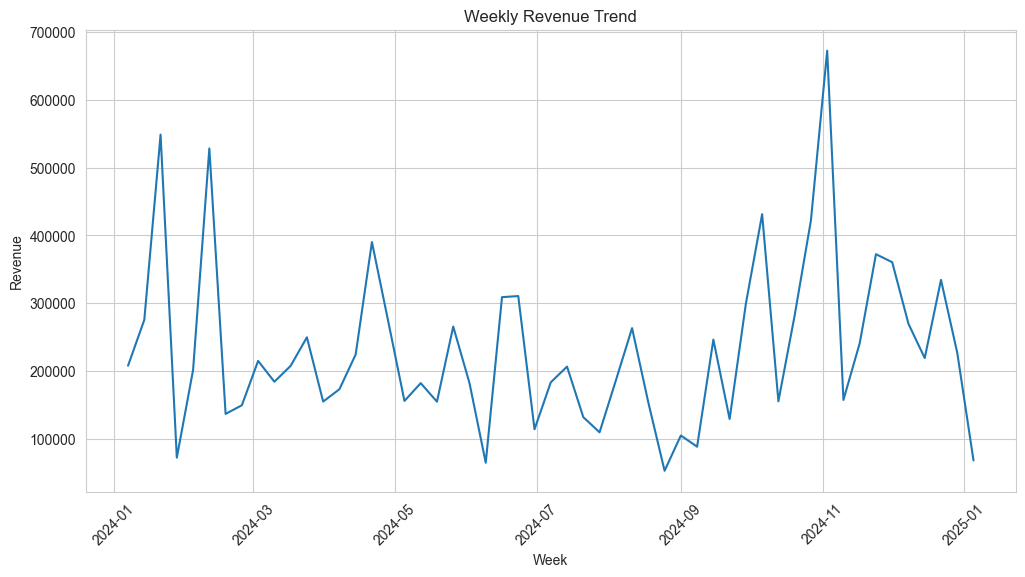

In [31]:
plt.figure(figsize=(12,6))

sns.lineplot(
    data=weekly_sales,
    x="orderdatum",
    y="revenue"
)

plt.title("Weekly Revenue Trend")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.xticks(rotation=45)

plt.show()


Interpretation:

This chart shows how revenue changes over time.
We can observe peaks and dips that may indicate seasonal demand,
marketing campaign impact, or operational performance changes.


### KPI 2 — Average Order Value (AOV)

Average Order Value shows how much revenue is generated per order.
It helps evaluate customer purchasing behavior and pricing effectiveness.


In [32]:
order_revenue = (
    df.groupby("order_id")["revenue"]
    .sum()
    .reset_index()
)


In [33]:
aov = order_revenue["revenue"].mean()

print("Average Order Value:", round(aov, 2))


Average Order Value: 8736.4


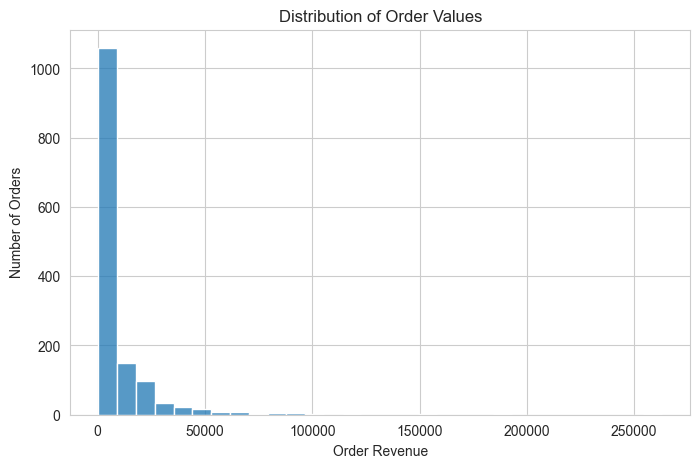

In [34]:
plt.figure(figsize=(8,5))

sns.histplot(order_revenue["revenue"], bins=30)

plt.title("Distribution of Order Values")
plt.xlabel("Order Revenue")
plt.ylabel("Number of Orders")

plt.show()


Interpretation:

This distribution shows how order values are spread across customers.
If most orders are low value, the business may benefit from bundling or upselling strategies.
High-value orders indicate strong purchasing power among certain customer segments.


### KPI 3 — Average Delivery Lead Time

Delivery lead time measures how many days it takes from order placement to delivery.
It is a key operational KPI used to evaluate logistics performance and customer experience.


In [35]:
avg_delivery_time = df["lead_time_days"].mean()

print("Average Delivery Lead Time:", round(avg_delivery_time, 2), "days")


Average Delivery Lead Time: 2.79 days


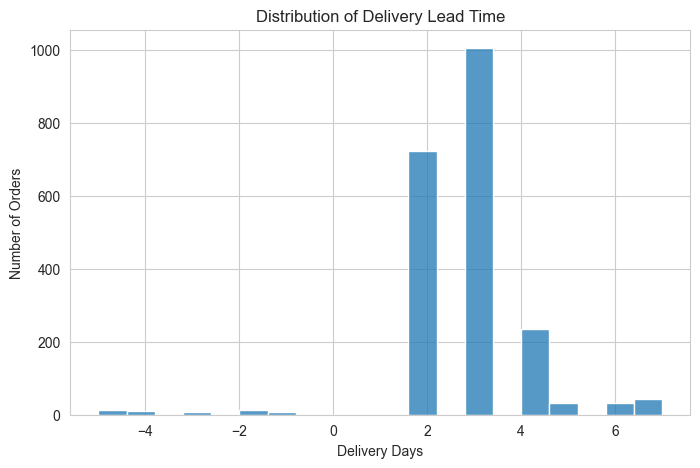

In [36]:
plt.figure(figsize=(8,5))

sns.histplot(df["lead_time_days"], bins=20)

plt.title("Distribution of Delivery Lead Time")
plt.xlabel("Delivery Days")
plt.ylabel("Number of Orders")

plt.show()


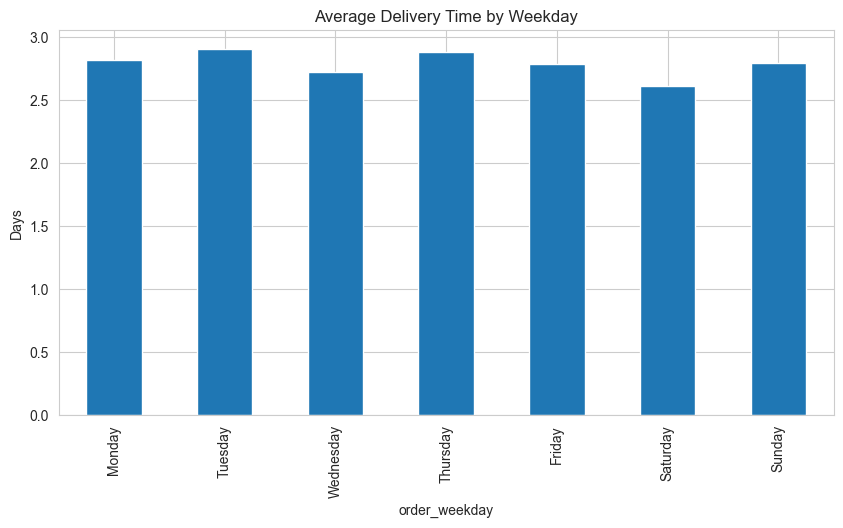

In [37]:
delivery_by_weekday = (
    df.groupby("order_weekday")["lead_time_days"]
    .mean()
    .reindex([
        "Monday","Tuesday","Wednesday",
        "Thursday","Friday","Saturday","Sunday"
    ])
)

plt.figure(figsize=(10,5))

delivery_by_weekday.plot(kind="bar")

plt.title("Average Delivery Time by Weekday")
plt.ylabel("Days")

plt.show()


Interpretation:

Delivery lead time indicates logistics efficiency.
Long delivery times may negatively impact customer satisfaction.
Weekday analysis can reveal operational bottlenecks or peak workload days.


### KPI 4 — Customer Sentiment Analysis

Customer reviews are classified into sentiment categories based on rating scores.
This provides insight into customer satisfaction trends.


In [38]:
def classify_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif rating <= 2:
        return "Negative"
    else:
        return "Unknown"

df["sentiment"] = df["betyg"].apply(classify_sentiment)


In [39]:
sentiment_counts = df["sentiment"].value_counts()

print(sentiment_counts)


sentiment
Unknown     1076
Positive     664
Neutral      193
Negative     188
Name: count, dtype: int64


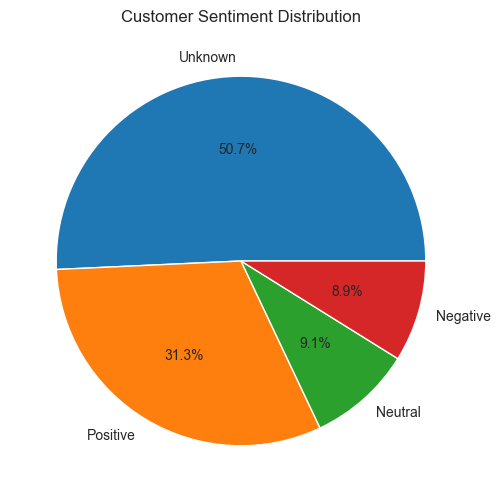

In [40]:
plt.figure(figsize=(6,6))

sentiment_counts.plot(kind="pie", autopct="%1.1f%%")

plt.title("Customer Sentiment Distribution")
plt.ylabel("")

plt.show()


Interpretation:

Customer sentiment indicates overall satisfaction levels.
A high percentage of positive sentiment suggests strong customer experience.
Negative sentiment highlights areas requiring operational or product improvements.
